In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from sklearn.cluster import KMeans

sns.set(color_codes = True)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
dir_path = 'Kroger_Retail_Dunnhumby/'

file1= dir_path + 'transaction_data.csv'
file2 = dir_path + 'hh_demographic.csv'
file3 = dir_path + 'coupon_redempt.csv'
file4= dir_path + 'coupon.csv'
file5 = dir_path + 'campaign_desc.csv'
file6 = dir_path + 'campaign_table.csv'
# file7= dir_path + 'causal_data.csv'
file8 = dir_path + 'product.csv'


In [3]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.columns = df.columns.str.lower()
    return df

In [4]:
# import data listings into dataframe
df_trans = load_data(file1)
df_trans.head()


household_key    basket_id  day  product_id  quantity  sales_value  store_id  retail_disc  trans_time  week_no  coupon_disc  coupon_match_disc
0           2375  26984851472    1     1004906         1         1.39       364        -0.60        1631        1          0.0                0.0
1           2375  26984851472    1     1033142         1         0.82       364         0.00        1631        1          0.0                0.0
2           2375  26984851472    1     1036325         1         0.99       364        -0.30        1631        1          0.0                0.0
3           2375  26984851472    1     1082185         1         1.21       364         0.00        1631        1          0.0                0.0
4           2375  26984851472    1     8160430         1         1.50       364        -0.39        1631        1          0.0                0.0

In [5]:
df_cus = load_data(file2)
df_cus.head()

age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc household_size_desc kid_category_desc  household_key
0      65+                   A      35-49K      Homeowner  2 Adults No Kids                   2      None/Unknown              1
1    45-54                   A      50-74K      Homeowner  2 Adults No Kids                   2      None/Unknown              7
2    25-34                   U      25-34K        Unknown     2 Adults Kids                   3                 1              8
3    25-34                   U      75-99K      Homeowner     2 Adults Kids                   4                 2             13
4    45-54                   B      50-74K      Homeowner     Single Female                   1      None/Unknown             16

In [6]:
df_coupon_redempt = load_data(file3)
df_coupon_redempt.shape

(2318, 4)

In [7]:
df_coupon = load_data(file4)
df_coupon.head()

coupon_upc  product_id  campaign
0  10000089061       27160         4
1  10000089064       27754         9
2  10000089073       28897        12
3  51800009050       28919        28
4  52100000076       28929        25

In [8]:
df_camp_des = pd.read_csv('DATA_CLEAN/campaign_details.csv')
df_camp_des.head()

description  campaign  start_day  end_day  duration  total_coupons  coupons_giveout
0       TypeA        26        224      264        40            181               16
1       TypeC        27        237      300        63             27               27
2       TypeB        28        259      320        61             28               28
3       TypeB        29        281      334        53             33               33
4       TypeA        30        323      369        46            181               16

In [9]:
df_camp_cus = load_data(file6)
df_camp_cus.head()

description  household_key  campaign
0       TypeA             17        26
1       TypeA             27        26
2       TypeA            212        26
3       TypeA            208        26
4       TypeA            192        26

In [10]:
# df_prod_causal = load_data(file7)
# df_prod_causal.head()

In [11]:
df_prod = load_data(file8)
df_prod.head()

product_id  manufacturer    department     brand            commodity_desc           sub_commodity_desc curr_size_of_product
0       25671             2       GROCERY  National                  FRZN ICE          ICE - CRUSHED/CUBED                22 LB
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION  NO SUBCOMMODITY DESCRIPTION                     
2       26093            69        PASTRY   Private                     BREAD         BREAD:ITALIAN/FRENCH                     
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE                  APPLE SAUCE                50 OZ
4       26355            69       GROCERY   Private             COOKIES/CONES            SPECIALTY COOKIES                14 OZ

In [12]:
arr_cus_unique = df_trans.household_key.unique()
print('Total households',len(arr_cus_unique))

# get customers receiving campaigns before day 587 (not receiving campaigns from 18 - 25)
arr_cus_camp = df_camp_cus.household_key.unique()
print('Households received campaigns',len(arr_cus_camp))

arr_cus_no_camp = set(arr_cus_unique)-set(arr_cus_camp)
print('Households did not receive campaigns',len(arr_cus_no_camp))

arr_cus_redempt = df_coupon_redempt.household_key.unique()
print('Households redeemed coupons',len(arr_cus_redempt))

arr_cus_no_redempt = set(arr_cus_camp)-set(arr_cus_redempt)
print('Households received coupons but did not redeem',len(arr_cus_no_redempt))


Total households 2500
Households received campaigns 1584
Households did not receive campaigns 916
Households redeemed coupons 434
Households received coupons but did not redeem 1150


In [13]:
df_household = pd.DataFrame(df_trans.household_key.unique())
df_household.columns = ['household_key']
df_household


household_key
0              2375
1              1364
2              1130
3              1173
4                98
...             ...
2495            615
2496           1077
2497           1581
2498           1984
2499           2325

[2500 rows x 1 columns]

In [14]:
# create household table with comprehensive details

df_household['received_campaign'] = 0
df_household.loc[df_household.household_key.isin(arr_cus_camp),'received_campaign'] = 1
df_household

household_key  received_campaign
0              2375                  1
1              1364                  1
2              1130                  1
3              1173                  0
4                98                  1
...             ...                ...
2495            615                  0
2496           1077                  0
2497           1581                  1
2498           1984                  0
2499           2325                  0

[2500 rows x 2 columns]

In [15]:
df_household['redeemed_coupons'] = 0
df_household.loc[df_household.household_key.isin(arr_cus_redempt),'redeemed_coupons'] = 1
df_household

household_key  received_campaign  redeemed_coupons
0              2375                  1                 1
1              1364                  1                 1
2              1130                  1                 1
3              1173                  0                 0
4                98                  1                 0
...             ...                ...               ...
2495            615                  0                 0
2496           1077                  0                 0
2497           1581                  1                 1
2498           1984                  0                 0
2499           2325                  0                 0

[2500 rows x 3 columns]

In [16]:
total_camps = df_camp_cus.groupby(['household_key']).count().reset_index()
total_camps = total_camps[['household_key','campaign']].rename(columns={'campaign':'total_campaigns_received'})
total_camps

df_household = df_household.merge(total_camps,how='left',on='household_key')
df_household.fillna(0,inplace=True)
df_household



household_key  received_campaign  redeemed_coupons  total_campaigns_received
0              2375                  1                 1                       2.0
1              1364                  1                 1                       5.0
2              1130                  1                 1                       6.0
3              1173                  0                 0                       0.0
4                98                  1                 0                       2.0
...             ...                ...               ...                       ...
2495            615                  0                 0                       0.0
2496           1077                  0                 0                       0.0
2497           1581                  1                 1                       2.0
2498           1984                  0                 0                       0.0
2499           2325                  0                 0                       0.0

[2500 rows x 4 columns]

In [17]:
total_camp_types = df_camp_cus.groupby(['household_key','description']).count()
total_camp_types


campaign
household_key description          
1             TypeA               3
              TypeB               4
              TypeC               1
2             TypeA               1
3             TypeA               2
...                             ...
2498          TypeC               1
2499          TypeA               2
2500          TypeA               3
              TypeB               4
              TypeC               1

[2933 rows x 1 columns]

In [18]:
t = total_camp_types.unstack(level=-1)
t
t.columns = ['TypeA','TypeB','TypeC']
t.fillna(0,inplace=True)

df_household = df_household.merge(t,how='left',on='household_key')
df_household


household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC
0              2375                  1                 1                       2.0    2.0    0.0    0.0
1              1364                  1                 1                       5.0    4.0    1.0    0.0
2              1130                  1                 1                       6.0    5.0    0.0    1.0
3              1173                  0                 0                       0.0    NaN    NaN    NaN
4                98                  1                 0                       2.0    1.0    0.0    1.0
...             ...                ...               ...                       ...    ...    ...    ...
2495            615                  0                 0                       0.0    NaN    NaN    NaN
2496           1077                  0                 0                       0.0    NaN    NaN    NaN
2497           1581                  1                 1                       2.0    1.0    1.0    0.0
2498           1984                  0                 0                       0.0    NaN    NaN    NaN
2499           2325                  0                 0                       0.0    NaN    NaN    NaN

[2500 rows x 7 columns]

In [19]:
total_camp_engaged = df_coupon_redempt.groupby(['household_key']).campaign.count().reset_index()
df_household = df_household.merge(total_camp_engaged,how='left',on='household_key')
df_household.fillna(0,inplace=True)

df_household.rename(columns={'campaign':'total_campaigns_engaged'},inplace=True)
df_household.head()


household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged
0           2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0
1           1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0
2           1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0
3           1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0
4             98                  1                 0                       2.0    1.0    0.0    1.0                      0.0

In [20]:
# Total coupons received for each household

total_coupons_received = df_camp_cus.merge(df_camp_des[['campaign','coupons_giveout']],how='left',on='campaign')
total_coupons_received = total_coupons_received.groupby('household_key').agg({'coupons_giveout':'sum'}).reset_index()
total_coupons_received

df_household = df_household.merge(total_coupons_received,how='left',on='household_key')
df_household.fillna(0,inplace=True)
df_household

df_household.rename(columns={'coupons_giveout':'total_coupons_received'},inplace=True)
df_household


household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received
0              2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0                    32.0
1              1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0
2              1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0
3              1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0
4                98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0
...             ...                ...               ...                       ...    ...    ...    ...                      ...                     ...
2495            615                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0
2496           1077                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0
2497           1581                  1                 1                       2.0    1.0    1.0    0.0                      1.0                    35.0
2498           1984                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0
2499           2325                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0

[2500 rows x 9 columns]

In [21]:
# Total coupons redeemed for each household

total_coupons_redempt = df_coupon_redempt.groupby(['household_key']).coupon_upc.count().reset_index()
df_household = df_household.merge(total_coupons_redempt,how='left',on='household_key')
df_household.fillna(0,inplace=True)

df_household.rename(columns={'coupon_upc':'total_coupons_redeemed'},inplace=True)
df_household.head()


household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed
0           2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0                    32.0                     9.0
1           1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0
2           1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0
3           1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0
4             98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0

In [22]:
# Calculate conversion rate

df_household['camp_conversion_rate'] = round(df_household.total_campaigns_engaged / df_household.total_campaigns_received,2)

df_household['coupon_conversion_rate'] = round(df_household.total_coupons_redeemed / df_household.total_coupons_received,2)
df_household.fillna(0,inplace=True)

df_household

household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate
0              2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0                    32.0                     9.0                  4.50                    0.28
1              1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0                  0.20                    0.01
2              1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0                  0.17                    0.01
3              1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00
4                98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0                  0.00                    0.00
...             ...                ...               ...                       ...    ...    ...    ...                      ...                     ...                     ...                   ...                     ...
2495            615                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00
2496           1077                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00
2497           1581                  1                 1                       2.0    1.0    1.0    0.0                      1.0                    35.0                     1.0                  0.50                    0.03
2498           1984                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00
2499           2325                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00

[2500 rows x 12 columns]

In [23]:
# Calculate RFM

last_transaction_date = df_trans.groupby('household_key').day.max().max()

df_rfm = df_trans.groupby('household_key').agg({'day': lambda x: last_transaction_date - x.max(),
                                                'basket_id':'nunique',
                                                'sales_value':'sum'})

df_rfm.columns = ['recency','frequency','monetary']
df_rfm = df_rfm.reset_index()
df_rfm.dtypes


household_key      int64
recency            int64
frequency          int64
monetary         float64
dtype: object

In [24]:
# Calculate RFM score based on quantile

df_rfm['r'] = pd.qcut(df_rfm.recency,4,[4,3,2,1]).astype(int)
df_rfm['f'] = pd.qcut(df_rfm.frequency,4,[1,2,3,4]).astype(int)
df_rfm['m'] = pd.qcut(df_rfm.monetary,4,[1,2,3,4]).astype(int)

df_rfm['rfm_score'] = df_rfm.r + df_rfm.f + df_rfm.m
df_rfm['rfm_group'] = df_rfm.r.astype(str) + df_rfm.f.astype(str) + df_rfm.m.astype(str)
df_rfm.head()

household_key  recency  frequency  monetary  r  f  m  rfm_score rfm_group
0              1        5         86   4330.16  3  3  3          9       333
1              2       43         45   1954.34  1  2  2          5       122
2              3        8         47   2653.21  2  2  3          7       223
3              4       84         30   1200.11  1  1  2          4       112
4              5        8         40    779.06  2  2  1          5       221

In [29]:
# Translate RFM score into segments

df_rfm['segment'] = pd.qcut(df_rfm.rfm_score,4,['Required activation', 'Need attention','Loyal','Champions'])
df_rfm.head()

household_key  recency  frequency  monetary  r  f  m  rfm_score rfm_group              segment
0              1        5         86   4330.16  3  3  3          9       333                Loyal
1              2       43         45   1954.34  1  2  2          5       122  Required activation
2              3        8         47   2653.21  2  2  3          7       223       Need attention
3              4       84         30   1200.11  1  1  2          4       112  Required activation
4              5        8         40    779.06  2  2  1          5       221  Required activation

(array([2.261e+03, 1.330e+02, 4.300e+01, 2.600e+01, 1.400e+01, 4.000e+00,
        7.000e+00, 3.000e+00, 1.000e+00, 8.000e+00]),
 array([  0. ,  65.7, 131.4, 197.1, 262.8, 328.5, 394.2, 459.9, 525.6,
        591.3, 657. ]),
 <BarContainer object of 10 artists>)

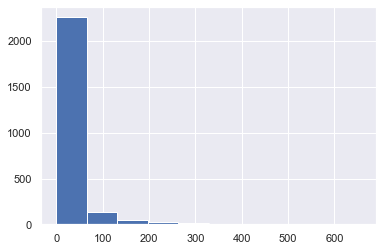

In [25]:
plt.hist(df_rfm.recency)


(array([1.777e+03, 5.300e+02, 1.230e+02, 3.900e+01, 1.800e+01, 4.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00]),
 array([1.0000e+00, 1.3090e+02, 2.6080e+02, 3.9070e+02, 5.2060e+02,
        6.5050e+02, 7.8040e+02, 9.1030e+02, 1.0402e+03, 1.1701e+03,
        1.3000e+03]),
 <BarContainer object of 10 artists>)

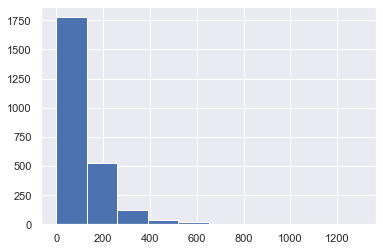

In [26]:
plt.hist(df_rfm.frequency)


(array([1.771e+03, 4.920e+02, 1.510e+02, 6.200e+01, 1.600e+01, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([8.1700000e+00, 3.8393320e+03, 7.6704940e+03, 1.1501656e+04,
        1.5332818e+04, 1.9163980e+04, 2.2995142e+04, 2.6826304e+04,
        3.0657466e+04, 3.4488628e+04, 3.8319790e+04]),
 <BarContainer object of 10 artists>)

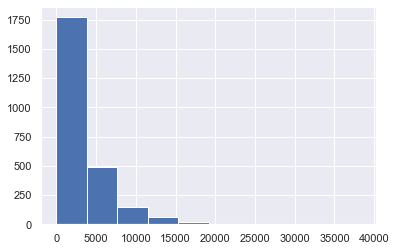

In [27]:
plt.hist(df_rfm.monetary)

(array([281., 206., 211., 263., 268., 263., 254., 260., 268., 226.]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ]),
 <BarContainer object of 10 artists>)

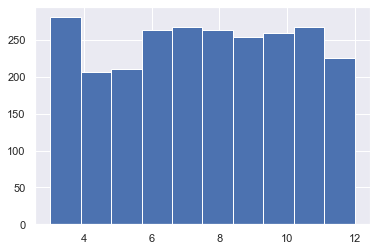

In [28]:
plt.hist(df_rfm.rfm_score)

(array([514.,   0.,   0., 698.,   0.,   0., 794.,   0.,   0., 494.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

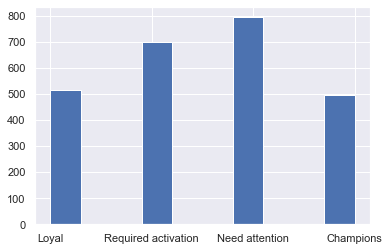

In [30]:
plt.hist(df_rfm.segment)

In [31]:
df_household.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   household_key             2500 non-null   int64  
 1   received_campaign         2500 non-null   int64  
 2   redeemed_coupons          2500 non-null   int64  
 3   total_campaigns_received  2500 non-null   float64
 4   TypeA                     2500 non-null   float64
 5   TypeB                     2500 non-null   float64
 6   TypeC                     2500 non-null   float64
 7   total_campaigns_engaged   2500 non-null   float64
 8   total_coupons_received    2500 non-null   float64
 9   total_coupons_redeemed    2500 non-null   float64
 10  camp_conversion_rate      2500 non-null   float64
 11  coupon_conversion_rate    2500 non-null   float64
dtypes: float64(9), int64(3)
memory usage: 253.9 KB


In [32]:
# Calculate total spend of each household for top 6 most-purchased product categories

product_category_list = ['GROCERY','DELI','PRODUCE','KIOSK-GAS','DRUG GM','NUTRITION','SALAD BAR','MEAT']

for c in product_category_list:
    # print(c)
    arr_prod_id = df_prod[df_prod.department==c]['product_id']
    
    df_total_spend = df_trans[df_trans.product_id.isin(arr_prod_id)].groupby('household_key').sales_value.sum().reset_index()
    
    new_name = c + '_spend'
    
    df_total_spend.rename(columns={'sales_value':new_name},inplace=True)
    
    df_household = df_household.merge(df_total_spend,how='left',on='household_key')


In [33]:
df_household.fillna(0,inplace=True)
df_household

household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate  GROCERY_spend  DELI_spend  PRODUCE_spend  KIOSK-GAS_spend  DRUG GM_spend  NUTRITION_spend  SALAD BAR_spend  MEAT_spend
0              2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0                    32.0                     9.0                  4.50                    0.28        1321.66       73.63         395.99             0.00         351.73             0.00             9.18      427.77
1              1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0                  0.20                    0.01        1188.86      130.46         135.51             0.00         317.94             2.77           110.54      242.27
2              1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0                  0.17                    0.01        3220.37      406.07         512.06            20.00         839.14            42.57            19.33      740.26
3              1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         249.99        1.95          24.65           153.35         162.14             5.00             0.00       17.90
4                98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0                  0.00                    0.00        1878.29       16.68          81.11             0.00         291.27            30.04             0.00      106.18
...             ...                ...               ...                       ...    ...    ...    ...                      ...                     ...                     ...                   ...                     ...            ...         ...            ...              ...            ...              ...              ...         ...
2495            615                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         102.28       17.41          43.06            86.47          22.05            16.84             0.00       33.85
2496           1077                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         841.00       27.32          32.19           256.98         153.15             0.00             0.00       72.66
2497           1581                  1                 1                       2.0    1.0    1.0    0.0                      1.0                    35.0                     1.0                  0.50                    0.03         798.46       36.12          70.48             0.00         154.53            11.06             0.00       41.33
2498           1984                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00          20.27        0.00           0.00             0.00          18.67             0.00             0.00        0.00
2499           2325                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00          7

In [34]:
df_cus_segnment = df_rfm[['household_key','recency','frequency','monetary','rfm_group','rfm_score','segment']]
df_cus_segnment.head()

household_key  recency  frequency  monetary rfm_group  rfm_score              segment
0              1        5         86   4330.16       333          9                Loyal
1              2       43         45   1954.34       122          5  Required activation
2              3        8         47   2653.21       223          7       Need attention
3              4       84         30   1200.11       112          4  Required activation
4              5        8         40    779.06       221          5  Required activation

In [35]:
# Calculate average values for each rfm group

rfm_level_agg = df_rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)

print(rfm_level_agg)

                    recency frequency monetary      
                       mean      mean     mean count
segment                                             
Required activation    69.9      28.1    711.2   698
Need attention         14.2      73.4   2064.4   794
Loyal                   6.2     135.4   4103.1   514
Champions               1.4     261.0   7718.3   494


In [36]:
df_household = df_household.merge(df_rfm[['household_key','recency','frequency','monetary','rfm_group','rfm_score','segment']],on='household_key')
df_household

household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate  GROCERY_spend  DELI_spend  PRODUCE_spend  KIOSK-GAS_spend  DRUG GM_spend  NUTRITION_spend  SALAD BAR_spend  MEAT_spend  recency  frequency  monetary rfm_group  rfm_score              segment
0              2375                  1                 1                       2.0    2.0    0.0    0.0                      9.0                    32.0                     9.0                  4.50                    0.28        1321.66       73.63         395.99             0.00         351.73             0.00             9.18      427.77        6        114   2841.40       333          9                Loyal
1              1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0                  0.20                    0.01        1188.86      130.46         135.51             0.00         317.94             2.77           110.54      242.27        1        145   2466.05       443         11            Champions
2              1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0                  0.17                    0.01        3220.37      406.07         512.06            20.00         839.14            42.57            19.33      740.26        0        362   6563.15       444         12            Champions
3              1173                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         249.99        1.95          24.65           153.35         162.14             5.00             0.00       17.90       74         41    655.77       121          4  Required activation
4                98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0                  0.00                    0.00        1878.29       16.68          81.11             0.00         291.27            30.04             0.00      106.18        1        205   2547.30       443         11            Champions
...             ...                ...               ...                       ...    ...    ...    ...                      ...                     ...                     ...                   ...                     ...            ...         ...            ...              ...            ...              ...              ...         ...      ...        ...       ...       ...        ...                  ...
2495            615                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         102.28       17.41          43.06            86.47          22.05            16.84             0.00       33.85       13         24    346.40       211          4  Required activation
2496           1077                  0                 0                       0.0    0.0    0.0    0.0                      0.0                     0.0                     0.0                  0.00                    0.00         841.00       27.32          32.19           256.98         153.15             0.00             0.00       72.66        6         36   1492.81       312          6       Need attention
2497           1581                  1                 1                       2.0    1.0    1.0    0.0                      1.0                    35.0                     1.0                  0.50                    0.03         798.46       36.12          70.48       

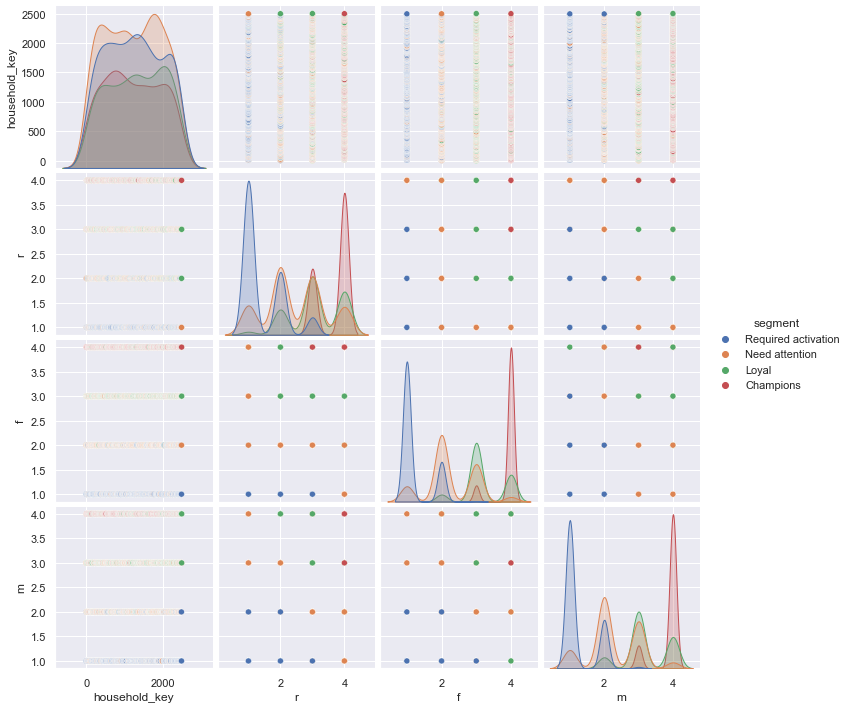

In [179]:
sns.pairplot(data=df_cus_segnment,hue='segment')

In [38]:
# Export household details into a new table
df_household_full = df_household.merge(df_cus,on='household_key',how='left')
df_household_full

df_household_full = df_household_full.sort_values('household_key')
df_household_full.to_csv('DATA_CLEAN/households_full_02.csv', index=False)


In [39]:
# Export household with demographic details into a new table
df_household_demo = df_household.merge(df_cus,on='household_key')
df_household_demo

df_household_demo.to_csv('DATA_CLEAN/households_demo_only_02.csv', index=False)

In [40]:
df_household_demo

household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate  GROCERY_spend  DELI_spend  PRODUCE_spend  KIOSK-GAS_spend  DRUG GM_spend  NUTRITION_spend  SALAD BAR_spend  MEAT_spend  recency  frequency  monetary rfm_group  rfm_score         segment age_desc marital_status_code income_desc homeowner_desc      hh_comp_desc household_size_desc kid_category_desc
0             1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0                  0.20                    0.01        1188.86      130.46         135.51             0.00         317.94             2.77           110.54      242.27        1        145   2466.05       443         11       Champions      65+                   B    100-124K      Homeowner     Single Female                   1      None/Unknown
1             1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0                  0.17                    0.01        3220.37      406.07         512.06            20.00         839.14            42.57            19.33      740.26        0        362   6563.15       444         12       Champions    55-64                   U      25-34K         Renter     2 Adults Kids                   3                 1
2               98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0                  0.00                    0.00        1878.29       16.68          81.11             0.00         291.27            30.04             0.00      106.18        1        205   2547.30       443         11       Champions    35-44                   U      35-49K        Unknown      1 Adult Kids                   2                 1
3             1172                  1                 0                       4.0    3.0    1.0    0.0                      0.0                    67.0                     0.0                  0.00                    0.00        2444.62       91.26         232.65            28.82         994.17            27.83            46.50      138.51        1        167   4569.24       444         12       Champions    25-34                   B      50-74K        Unknown       Single Male                   1      None/Unknown
4             1060                  1                 0                       9.0    5.0    4.0    0.0                      0.0                   141.0                     0.0                  0.00                    0.00        3796.27      376.59         230.63            22.44         845.47             0.00             0.00      477.01       39         64   6096.93       124          7  Need attention    35-44                   B      35-49K         Renter  2 Adults No Kids                   2      None/Unknown
..             ...                ...               ...                       ...    ...    ...    ...                      ...                     ...                     ...                   ...                     ...            ...         ...            ...              ...            ...              ...              ...         ...      ...        ...       ...       ...        ...             ...      ...                 ...         ...            ...               ...                 ...               ...
796           1678                  1                 0                       4.0    3.0    1.0    0.0                      0.0                    59.0                     0.0                  0.00                    0.00        1266.41       26.49          74.70            18.00         675.53             7.68             0.00      213.47       12        

In [41]:
# get all numerical columns
numerical_dtypes = ['int16','int32', 'int64','float16','float32','float64']
num_cols = []
for i in df_household_demo.columns:
    if df_household_demo[i].dtype in numerical_dtypes:
        num_cols.append(i)
        
print(len(num_cols))
print(num_cols)

cat_cols = df_household_demo.columns.difference(num_cols)
print(len(cat_cols))
print(cat_cols)

24
['household_key', 'received_campaign', 'redeemed_coupons', 'total_campaigns_received', 'TypeA', 'TypeB', 'TypeC', 'total_campaigns_engaged', 'total_coupons_received', 'total_coupons_redeemed', 'camp_conversion_rate', 'coupon_conversion_rate', 'GROCERY_spend', 'DELI_spend', 'PRODUCE_spend', 'KIOSK-GAS_spend', 'DRUG GM_spend', 'NUTRITION_spend', 'SALAD BAR_spend', 'MEAT_spend', 'recency', 'frequency', 'monetary', 'rfm_score']
9
Index(['age_desc', 'hh_comp_desc', 'homeowner_desc', 'household_size_desc', 'income_desc', 'kid_category_desc', 'marital_status_code', 'rfm_group', 'segment'], dtype='object')


In [49]:
# plot MontlyIncome of all numerical columns

def plot_multi_charts(data, x_column_list, y, title, y_label, plot_type, figsize):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.8, wspace=0.4, top=0.96)
    fig.suptitle(title)

    for i, col in enumerate(list(data[x_column_list]),1):
        
        ax = fig.add_subplot(len(x_column_list), 3, i)
        
        if plot_type == 'scatter':
            plt.scatter(x=data[col], y=data[y])
            plt.xlabel('{}'.format(col), size=15,labelpad=12.5)
            plt.ylabel(y_label, size=15, labelpad=12.5)
        elif plot_type == 'bar':
            data.groupby(col).agg({y:'mean'}).sort_values(by=y,ascending=False).plot.bar(ax=ax)
        
        plt.xticks(rotation=90)
#     figname = title + '.png'
#     fig.savefig(figname,transparent=False, bbox_inches='tight', dpi=300)
   
    plt.xticks(rotation=45)
    plt.show()
    

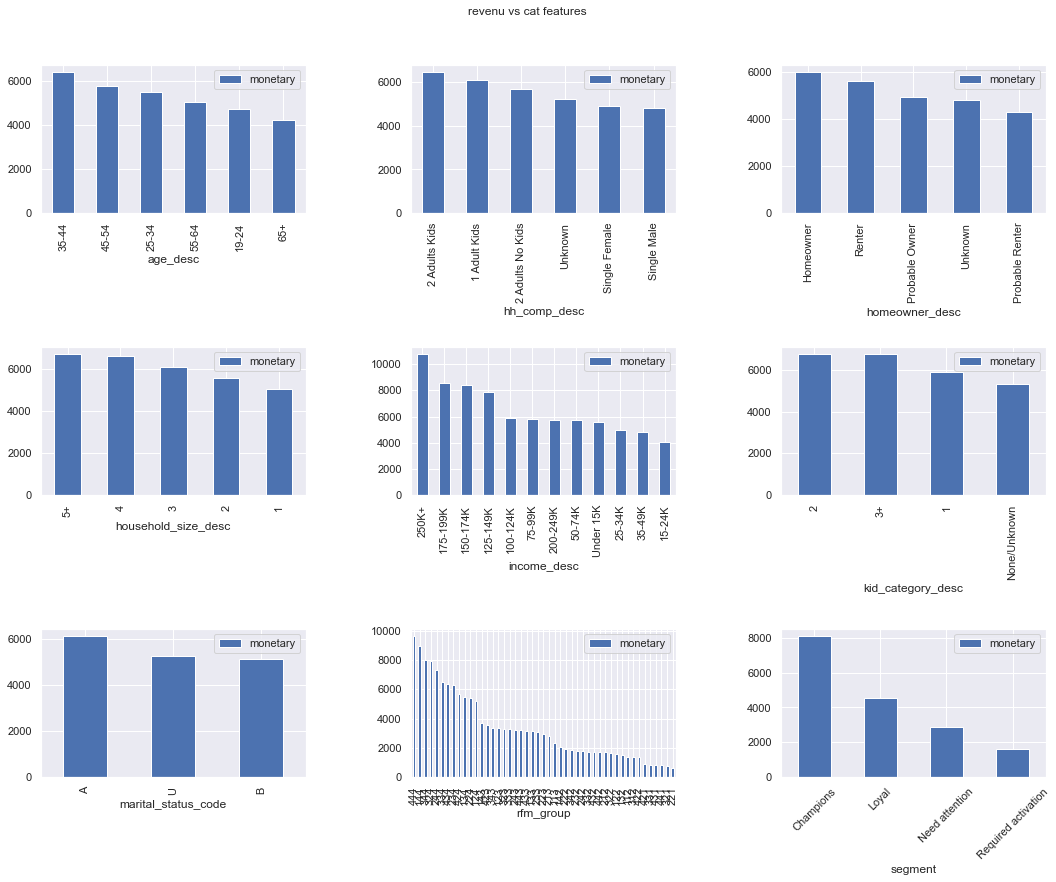

In [53]:
plot_multi_charts(data=df_household_demo, x_column_list=cat_cols,y='monetary', 
                  title='revenu vs cat features',y_label='revenue',plot_type='bar',figsize=(18,40))    

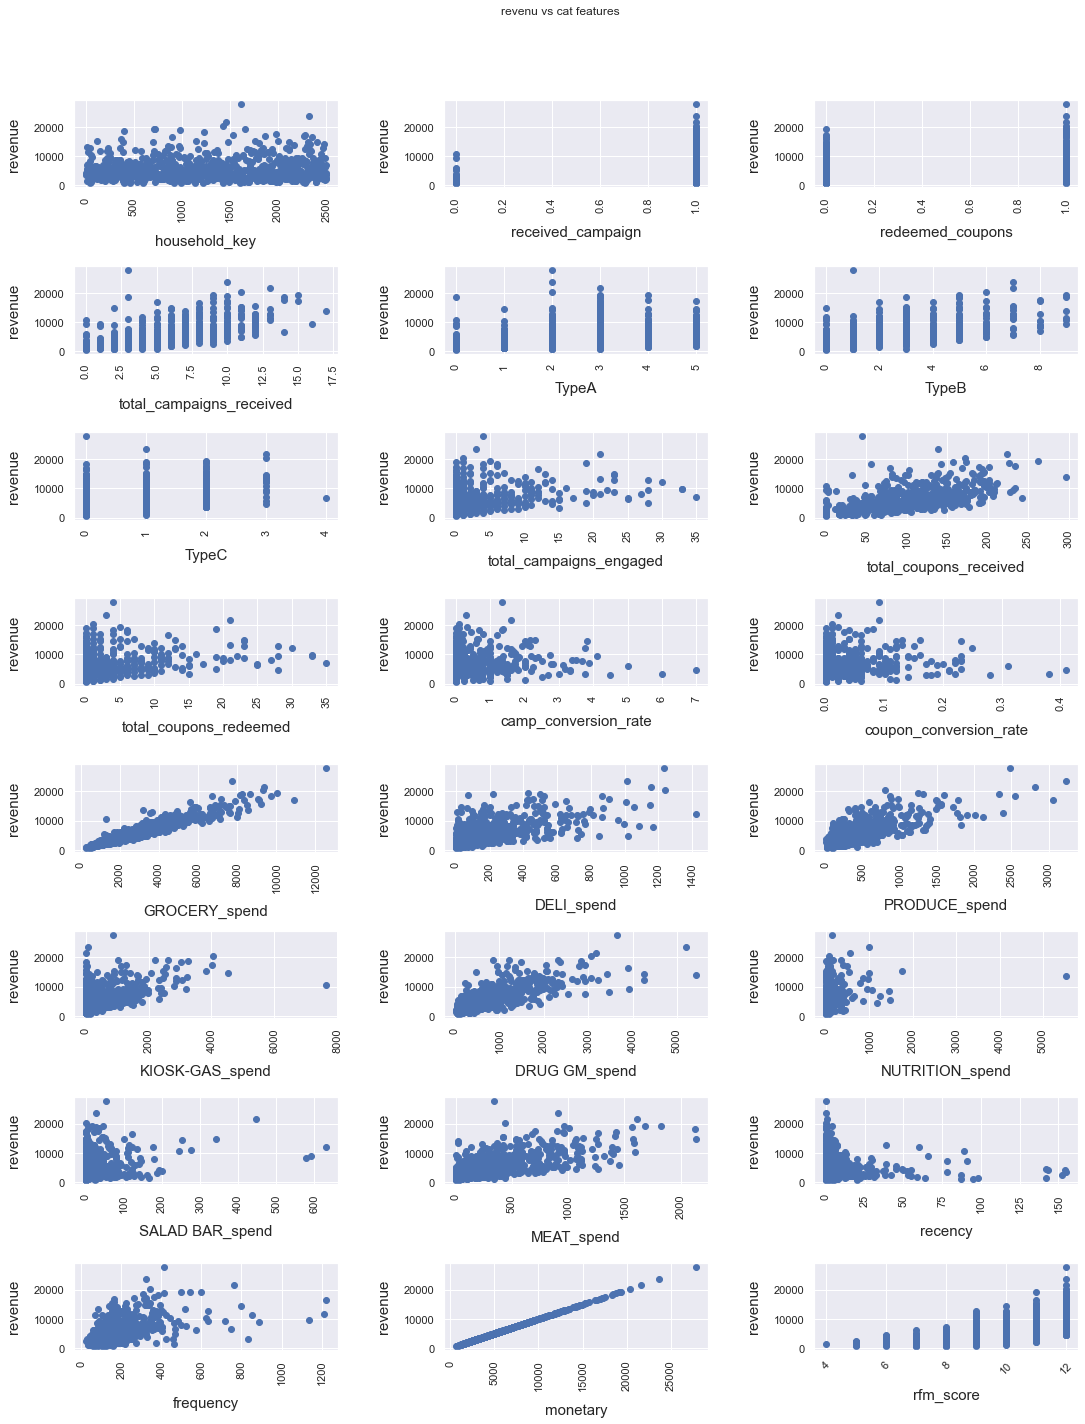

In [51]:
plot_multi_charts(data=df_household_demo, x_column_list=num_cols,y='monetary', 
                  title='revenu vs cat features',y_label='revenue',plot_type='scatter',figsize=(18,65))    

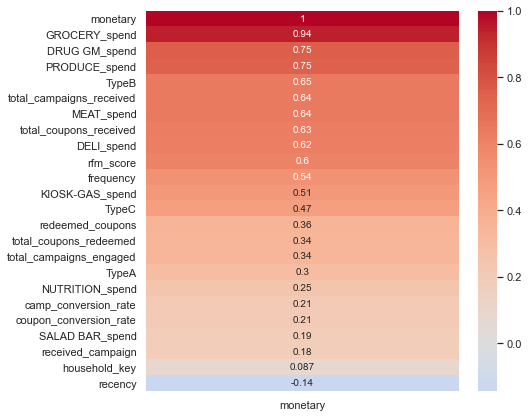

In [54]:
figure = plt.figure(figsize=(7,7))
sns.heatmap(df_household_demo.corr()[['monetary']].sort_values('monetary',ascending=False),annot=True, cmap='coolwarm', center=0);


/Users/chautran/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


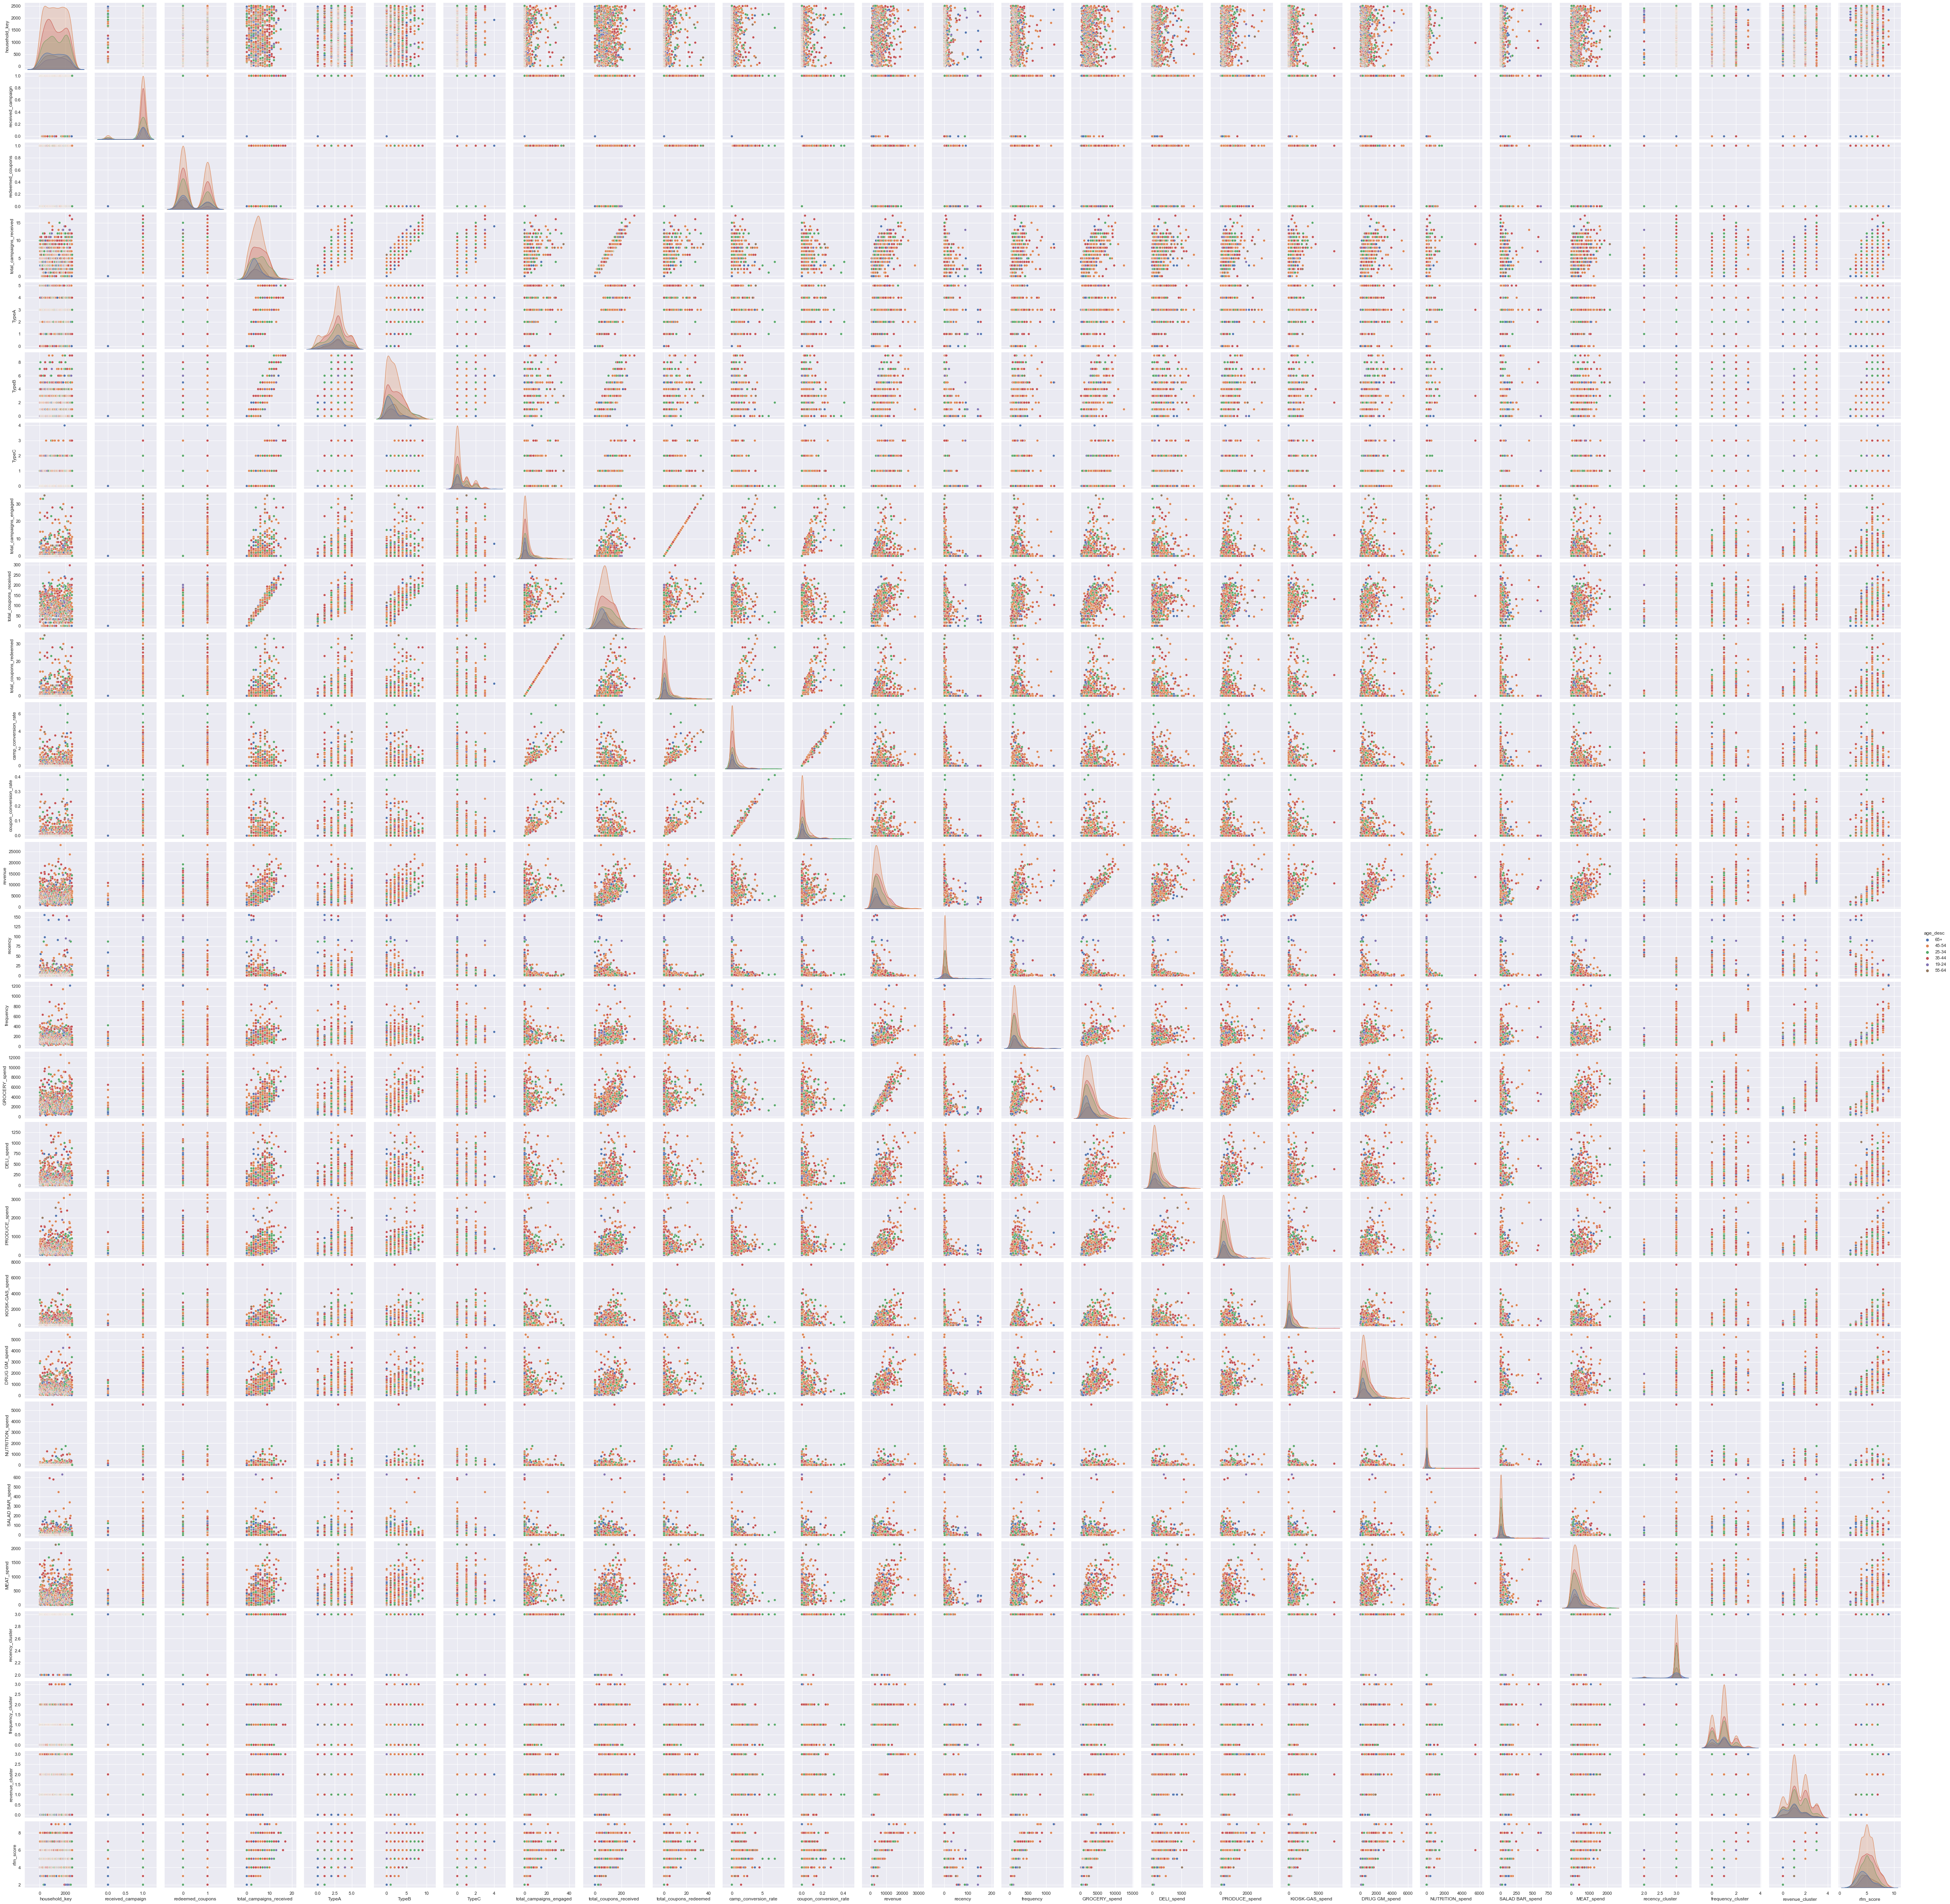

In [58]:
sns.pairplot(df_household_demo,hue='age_desc')

In [55]:
df_household_demo_encoded = pd.get_dummies(data = df_household_demo, columns = cat_cols)
df_household_demo_encoded.head()

household_key  received_campaign  redeemed_coupons  total_campaigns_received  TypeA  TypeB  TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate  GROCERY_spend  DELI_spend  PRODUCE_spend  KIOSK-GAS_spend  DRUG GM_spend  NUTRITION_spend  SALAD BAR_spend  MEAT_spend  recency  frequency  monetary  rfm_score  age_desc_19-24  age_desc_25-34  age_desc_35-44  age_desc_45-54  age_desc_55-64  age_desc_65+  hh_comp_desc_1 Adult Kids  hh_comp_desc_2 Adults Kids  hh_comp_desc_2 Adults No Kids  hh_comp_desc_Single Female  hh_comp_desc_Single Male  hh_comp_desc_Unknown  homeowner_desc_Homeowner  homeowner_desc_Probable Owner  homeowner_desc_Probable Renter  homeowner_desc_Renter  homeowner_desc_Unknown  household_size_desc_1  household_size_desc_2  household_size_desc_3  household_size_desc_4  household_size_desc_5+  income_desc_100-124K  income_desc_125-149K  income_desc_15-24K  income_desc_150-174K  income_desc_175-199K  \
0           1364                  1                 1                       5.0    4.0    1.0    0.0                      1.0                    77.0                     1.0                  0.20                    0.01        1188.86      130.46         135.51             0.00         317.94             2.77           110.54      242.27        1        145   2466.05         11               0               0               0               0               0             1                          0                           0                              0                           1                         0                     0                         1                              0                               0                      0                       0                      1                      0                      0                      0                       0                     1                     0                   0                     0                     0   
1           1130                  1                 1                       6.0    5.0    0.0    1.0                      1.0                   114.0                     1.0                  0.17                    0.01        3220.37      406.07         512.06            20.00         839.14            42.57            19.33      740.26        0        362   6563.15         12               0               0               0               0               1             0                          0                           1                              0                           0                         0                     0                         0                              0                               0                      1                       0                      0                      0                      1                      0                       0                     0                     0                   0                     0                     0   
2             98                  1                 0                       2.0    1.0    0.0    1.0                      0.0                    50.0                     0.0                  0.00                    0.00        1878.29       16.68          81.11             0.00         291.27            30.04             0.00      106.18        1        205   2547.30         11               0               0               1               0               0             0                          1                           0                              0                           0                         0                     0                         0                              0                               0                      0                       1                      0                      1                      0                      0                       0                     0                     0                   0                     0                     0   
3  

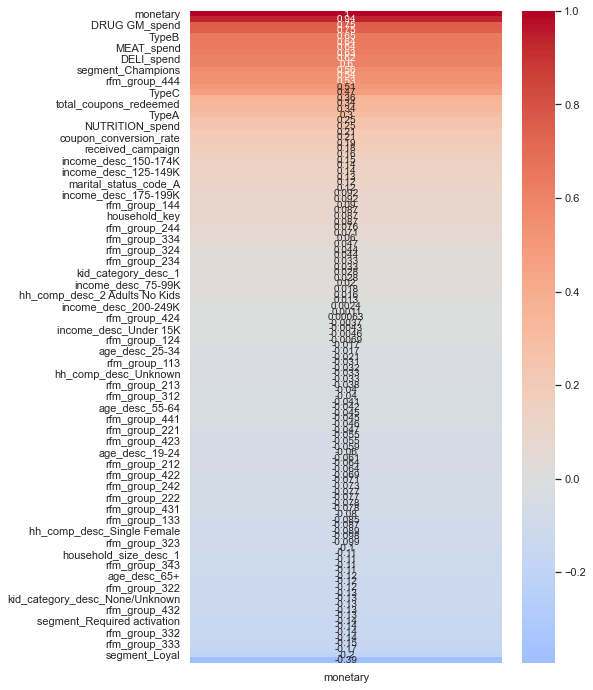

In [56]:
figure = plt.figure(figsize=(7,12))
sns.heatmap(df_household_demo_encoded.corr()[['monetary']].sort_values('monetary',ascending=False),annot=True, cmap='coolwarm', center=0);


In [57]:
df_household_demo.corr()

household_key  received_campaign  redeemed_coupons  total_campaigns_received     TypeA     TypeB     TypeC  total_campaigns_engaged  total_coupons_received  total_coupons_redeemed  camp_conversion_rate  coupon_conversion_rate  GROCERY_spend  DELI_spend  PRODUCE_spend  KIOSK-GAS_spend  DRUG GM_spend  NUTRITION_spend  SALAD BAR_spend  MEAT_spend   recency  frequency  monetary  rfm_score
household_key                  1.000000          -0.012685          0.052292                  0.053670 -0.035921  0.071882  0.097317                 0.048928                0.054529                0.048928              0.055572                0.057883       0.069175    0.049741       0.112654         0.026587       0.061169         0.043139         0.026817    0.072689  0.015183   0.010491  0.086696  -0.002621
received_campaign             -0.012685           1.000000          0.185041                  0.381630  0.477696  0.240254  0.137562                 0.107743                0.370166                0.107743              0.112620                0.112409       0.173692    0.120142       0.123159         0.103886       0.142063         0.034872         0.028006    0.127932 -0.053960   0.145648  0.183831   0.303880
redeemed_coupons               0.052292           0.185041          1.000000                  0.345896  0.234286  0.318397  0.202928                 0.582267                0.349370                0.582267              0.608624                0.607484       0.347705    0.177296       0.265035         0.255786       0.202982         0.036715        -0.019532    0.279214 -0.096634   0.155602  0.356533   0.283422
total_campaigns_received       0.053670           0.381630          0.345896                  1.000000  0.693841  0.889166  0.640913                 0.383987                0.981006                0.383987              0.141587                0.137910       0.647471    0.368077       0.426937         0.314959       0.517206         0.150280         0.085683    0.388913 -0.139486   0.390208  0.642299   0.528868
TypeA                         -0.035921           0.477696          0.234286                  0.693841  1.000000  0.351531  0.247675                 0.224490                0.676378                0.224490              0.096520                0.092301       0.304875    0.199134       0.199508         0.167632       0.215744         0.057499         0.023398    0.204208 -0.074040   0.217523  0.299344   0.386486
TypeB                          0.071882           0.240254          0.318397                  0.889166  0.351531  1.000000  0.476206                 0.366087                0.860526                0.366087              0.133678                0.134504       0.641066    0.359148       0.440566         0.312436       0.541930         0.163884         0.111126    0.361919 -0.140915   0.384396  0.645212   0.468912
TypeC                          0.097317           0.137562          0.202928                  0.640913  0.247675  0.476206  1.000000                 0.253584                0.667242                0.253584              0.073139                0.062844       0.492379    0.249138       0.280099         0.204444       0.362577         0.097363         0.025005    0.320425 -0.084153   0.243335  0.469302   0.308638
total_campaigns_engaged        0.048928           0.107743          0.582267                  0.383987  0.224490  0.366087  0.253584                 1.000000                0.384911                1.000000              0.837738                0.828012       0.329906    0.164761       0.237519         0.286928       0.212545         0.047145         0.019365    0.217463 -0.101030   0.145578  0.344357   0.250479
total_coupons_received         0.054529           0.370166          0.349370                  0.981006  0.676378  0.860526  0.667242                 0.384911                1.000000                0.384911              0.145336                0.132578       0.647619    0.368748       0.421956       